In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
pd.set_option('display.max_rows', None)
import zipfile
import os
import shutil

In [2]:
scenario_name = "twc1nv20"
path_to_zip_file = '/home/ai6644/Malmo/Tools/Simulation results/Lolland/stretched time windows/'+\
                   scenario_name+'/log.zip'

In [3]:
day_sec = int(86400)
day_h = int(24)

In [4]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path = 'data/zip/' + os.listdir('data/zip')[0] + '/vehicle_logs'

In [5]:
# all_files = glob.glob(path + "/vehicle_occupancy_*")
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_occupancy_*")
all_files.sort()

occupancies = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['time'] = df.time.astype(int)
    df = df.drop_duplicates(keep='last', subset='time')
    occupancies.append(df)

merged_time = pd.concat(occupancies)['time'].sort_values().drop_duplicates()

# for df in occupancies:
#     df['time'] = df.time.astype(int).drop_duplicates()
#     df.set_index('time', inplace=True)
    
# merged_df = pd.concat(occupancies, axis=1).fillna(method='ffill')

In [6]:
n_cars = len(all_files)

In [7]:
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_status_*")
all_files.sort()

statuses = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    df.columns = ['time', 'status']
    df['time'] = df.time.astype(int)
    df = df.drop_duplicates(keep='last', subset='time')
    statuses.append(df)

In [8]:
for occ,stat in zip(occupancies, statuses):
    occ.set_index('time', inplace=True)
    stat.set_index('time', inplace=True)
    # idle
    occ['#passengers'].loc[(stat.status == 6).values] = -2
    # waiting outside depot
    occ['#passengers'].loc[(stat.status == 4).values] = -1
    
merged_df = pd.concat(occupancies, axis=1).fillna(method='ffill')

In [9]:
li=[]
for i in range(0, len(merged_df)):
    li.append(merged_df.iloc[i].value_counts())
#     li[-1].index = 8 - li[-1].index.values

In [10]:
day_values = pd.concat(li, axis=1).fillna(0).T.reindex(index=[_ for _ in range(0, day_sec)]).fillna(method='ffill')

In [11]:
day_values = day_values[day_values.columns.to_list()[::-1]]

In [12]:
day_values.columns = day_values.columns.to_list()[:-2] + ['waiting', 'idling']

In [13]:
day_values2 = day_values.copy()
day_values2['idling'] = day_values2.idling + day_values2.waiting
day_values2 = day_values2.drop(['waiting'], axis=1)

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


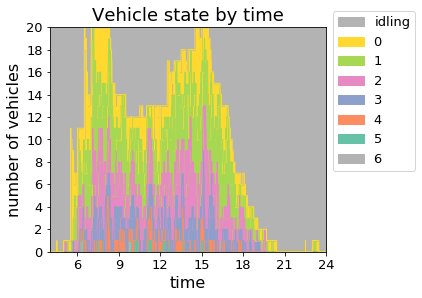

In [14]:
from matplotlib import cm
import matplotlib.patches as mpatches
# color_list = [i for i in cm.get_cmap("Set2").colors]*2
color_list = [i for i in [c for c in cm.get_cmap("Set2").colors[:-2]] + [cm.get_cmap("Set2").colors[-1]]]*4

fig = plt.figure()
ax = fig.add_axes([0.12, 0.13, 0.64, 0.78])
ax.set_ylabel('number of vehicles', {'fontsize': 16})
ax.set_xlabel('time', {'fontsize': 16})
ax.set_title('Vehicle state by time', {'fontsize': 18})
# day_values2.plot.area(stacked=True, ax=ax, linewidth=1)
day_values2.plot.area(stacked=True, ax=ax, linewidth=1, color=color_list[len(color_list)-len(day_values2.columns):])
labels = [day_values2.columns.to_list()[::-1][0]] + [str(int(l))+' ' for l in day_values2.columns.to_list()[::-1][1:]]
leg = [mpatches.Patch(color=c, label=l) for l,c in zip(labels,color_list[len(color_list)-len(day_values2.columns):][::-1])]
plt.legend(handles=leg, bbox_to_anchor=(1, 1.1), fontsize=13)
plt.xticks(np.linspace(0, day_sec, 9), np.linspace(0, day_h, 9, dtype='int'), fontsize=13)
plt.yticks(np.linspace(0, n_cars, 11), np.linspace(0, n_cars, 11, dtype='int'), fontsize=13)
plt.ylim(0,n_cars)
plt.xlim(4*60*60,day_sec)
# plt.gcf().subplots_adjust(right=0.8)
plt.savefig('data/occupancy.png', dpi=600)

In [15]:
# occ_by_time = {-2: 0, -1:0, 0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
occ_by_time = {i:0 for i in range(-2, 8+1)}
for i,j in zip(merged_df.iterrows(), merged_df.iloc[1:].iterrows()):
    for el in i[1].to_list():
        occ_by_time[el] += j[0]-i[0]

(0, 30000)

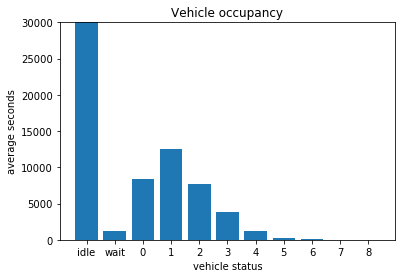

In [16]:
fig = plt.figure()
ax = plt.subplot(111)

plt.bar(['idle', 'wait'] + [str(i) for i in range(0,8+1)], [i / n_cars for i in list(occ_by_time.values())])
ax.set_ylabel('average seconds')
ax.set_xlabel('vehicle status')
ax.set_title('Vehicle occupancy')
plt.ylim(0, 30000)

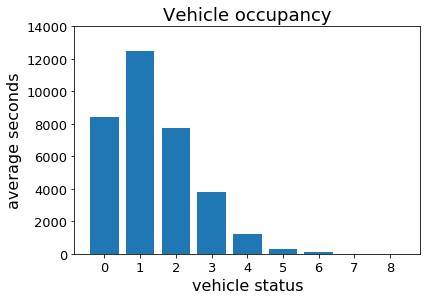

In [21]:
fig = plt.figure()
# ax = plt.subplot(111)
ax = fig.add_axes([0.16, 0.13, 0.8, 0.79])
plt.bar([str(i) for i in range(0,8+1)], [i / n_cars for i in list(occ_by_time.values())[2:]])
ax.set_ylabel('average seconds', fontsize=16)
ax.set_xlabel('vehicle status', fontsize=16)
ax.set_title('Vehicle occupancy', fontsize=18)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylim(0, 14000)
plt.savefig('data/occupancy_hist.png', dpi=600)

Text(0.5, 1.0, 'Vehicle occupancy')

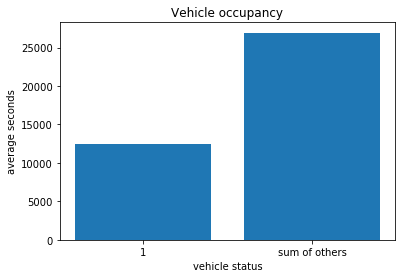

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
plt.bar(['1','sum of others'], [list(occ_by_time.values())[3]/n_cars] +\
        [list(occ_by_time.values())[4]/n_cars*2 + list(occ_by_time.values())[5]/n_cars*3])
ax.set_ylabel('average seconds')
ax.set_xlabel('vehicle status')
ax.set_title('Vehicle occupancy')

In [23]:
day_values.head()

,6.0,5.0,4.0,3.0,2.0,1.0,0.0,waiting,idling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [24]:
try:
    day_values['total'] = (day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
    day_values['total'] = (day_values[4.0]*4 + day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
    day_values['total'] = (day_values[5.0]*5 + day_values[4.0]*4 + day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
    day_values['total'] = (day_values[6.0]*6 + day_values[5.0]*5 + day_values[4.0]*4 + day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
    day_values['total'] = (day_values[7.0]*7 + day_values[6.0]*6 + day_values[5.0]*5 + day_values[4.0]*4 + day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
    day_values['total'] = (day_values[8.0]*8 + day_values[7.0]*7 + day_values[6.0]*6 + day_values[5.0]*5 + day_values[4.0]*4 + day_values[3.0]*3 + day_values[2.0]*2 + day_values[1.0])/n_cars
except:
    pass
day_values.total.loc[3*3600:].describe()

count    75600.000000
mean         0.611911
std          0.551346
min          0.000000
25%          0.000000
50%          0.600000
75%          1.100000
max          2.050000
Name: total, dtype: float64

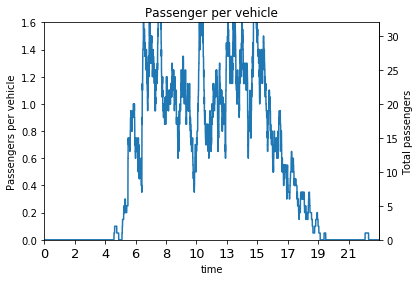

In [29]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_ylabel('Passengers per vehicle')
ax.set_xlabel('time')
ax.set_title('Passenger per vehicle')
plt.xticks(np.linspace(0, day_sec, 12), np.linspace(0, day_h, 12, dtype='int'), fontsize=13)
# plt.xticks([0, 21600, 43200, 64800, 86400], [0, 6, 12, 18, 24])
secaxy = ax.secondary_yaxis('right', functions=(lambda x: x*n_cars, lambda x: x/n_cars))
secaxy.set_ylabel('Total passengers')
day_values.total.plot()
plt.ylim(0,1.6)
plt.savefig('data/passengers_in_vehicle.png', dpi=600)

In [26]:
day_values['nowork'] = day_values.waiting + day_values.idling
print(day_sec - day_values.nowork.sum()/n_cars, ' - mean working seconds')

34048.95  - mean working seconds


In [27]:
print((day_sec - day_values.nowork.sum()/n_cars)/60/60, ' - mean working hours')

9.458041666666666  - mean working hours
